# Phase 1, Step 4: Data wrangling / EDA

To recap from the project proposal, we want to build (1) a Spell Checker, (2) a Part Of Speech (POS) Tagger, and (3) a Sentiment Analyzer (SA) for tweets in Spanish-English code switching text. Hence we split this exploration into 3.

## 1. General / Spell Checker

The "lid" (Language IDentification) corpus "train" portion contains 21030 tweets. The first column is a token within a tweet, and the second column is a language label for that token. The language label is always one of the following: "fw, lang1, lang2, mixed, ne, other, unk". Here "lang1" is English, "lang2" is Spanish, "mixed" is for partially in both languages, "fw" means other than the two languages, "ne" is for named entities, "ambiguous" is for either one or the other language, and "unk" is for unrecognizable.

I will build out a Spell Checker using this "train" portion, use the "dev" portion (3332 tweets) to tune it, and modify a sampling of tweets in the "test" portion (8289 tweets) for the final evaluation.

In [1]:
lid_train_file = "~/Documents/Springboard-notes-data/lince/lid_spaeng/train.conll"

In [2]:
import pandas as pd
import numpy as np

We dump the entire file into a Pandas dataframe.

In [3]:
df = pd.read_csv(lid_train_file, engine='python', sep='\t+', header=None, names=['token', 'language'], encoding='utf-8')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274251 entries, 0 to 274250
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   token     274249 non-null  object
 1   language  253221 non-null  object
dtypes: object(2)
memory usage: 4.2+ MB


In [5]:
df.head()

,token,language
0,# sent_enum = 1,None
1,11:11,other
2,.....,other
3,make,lang1
4,a,lang1


In [6]:
df = df.dropna()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253219 entries, 1 to 274250
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   token     253219 non-null  object
 1   language  253219 non-null  object
dtypes: object(2)
memory usage: 5.8+ MB


In [8]:
df.describe()

,token,language
count,253219,253219
unique,39192,8
top,.,lang2
freq,5663,112987


In [9]:
df.language.value_counts()

lang2        112987
lang1         80437
other         54060
ne             5186
ambiguous       266
unk             218
mixed            42
fw               23
Name: language, dtype: int64

In [10]:
df.token.value_counts()[:10]

.      5663
de     4022
,      3775
a      3686
!      3255
que    3239
I      2579
me     2531
y      2474
no     2152
Name: token, dtype: int64

In [11]:
df.token.value_counts()[:250]

.         5663
de        4022
,         3775
a         3686
!         3255
          ... 
as         115
tiene      115
really     113
👌          113
dia        113
Name: token, Length: 250, dtype: int64

In [12]:
df.token.value_counts()[:250].keys().values

array(['.', 'de', ',', 'a', '!', 'que', 'I', 'me', 'y', 'no', 'la', 'el',
       'en', '"', '..', ':', '!!', 'to', '?', 'the', 'es', 'you', 'con',
       'un', 'my', 'te', 'lo', 'para', 'mi', 'it', 'se', 'and', 'i', 'tu',
       'por', 'los', 'lol', 'is', 'yo', '…', 'las', 'si', 'in', 'una',
       'for', 'ya', 'of', "n't", 'that', '❤', 'pero', ':)', 'como', '️',
       "'s", 'do', 'like', 'lmao', 'with', 'be', 'hoy', 'so', 'on', '“',
       '😂', 'El', 'No', '...', 'del', 'up', 'esta', '”', "'m", 'your',
       'but', 'have', 'just', 'this', 'u', 'al', 'all', '!!!', 'at',
       'get', 'go', 'too', 'was', 'can', 'jajaja', 'La', 'he', 'A', 'Me',
       '#elvacilondelagatita', 'are', '@JimmyEsqueda', 'out', 'Y', 'bien',
       'le', 'todo', 'love', 'más', 'know', 'Que', 'q', 'este', 'we',
       'not', 'tengo', 'mas', 'My', 'voy', 'vlog', 'pa', 'eso', 'day',
       'quiero', 'mejor', 'gracias', 'Ya', '(', 'mis', 'Gracias', 'o',
       'cuando', '&', 'estoy', 'one', 'ser', 'hay', '*', 'by

In [13]:
token_counts = df.token.value_counts().values

In [14]:
from collections import Counter

count_counter = Counter()

for count in token_counts:
    count_counter[count] += 1

Now let's see how many tokens are encountered only once. Recall that this is out of 253219 tokens.

In [15]:
count_counter[1]

25905

So, about one in every 10 tokens is unique!

In [16]:
x, y = list(count_counter.keys()), list(count_counter.values())

In [17]:
x[:10], y[:10]

([5663, 4022, 3775, 3686, 3255, 3239, 2579, 2531, 2474, 2152],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

We plot the count of counts.

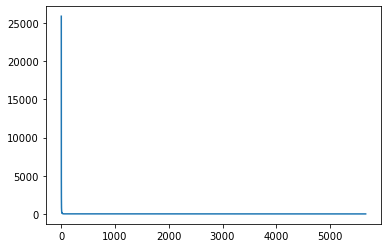

In [18]:
from matplotlib import pyplot as plt

plt.plot(x, y)

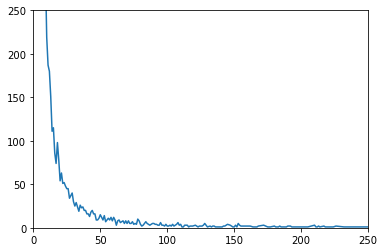

In [19]:
plt.ylim(0, 250)
plt.xlim(0, 250)
plt.plot(x, y)

This is a very sharp power law distribution. It might look better if we take the log of the y-axis...

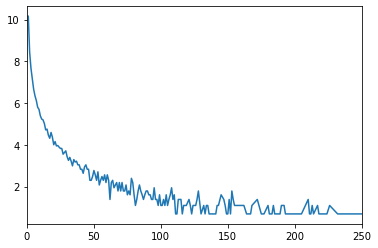

In [20]:
plt.xlim(0, 250)
plt.plot(x, np.log1p(y))

...or the log of the log...

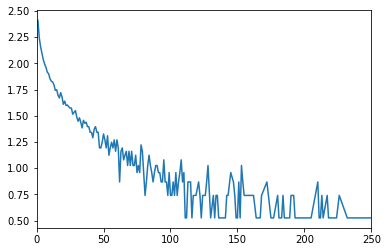

In [21]:
plt.xlim(0, 250)
plt.plot(x, np.log1p(np.log1p(y)))

### General Remarks

According to [1], the frequent alternations between two languages is what makes the automated processing of code-switching data difficult. This is quantified by using the CMI index. In the case of Spanish-English code switched text, there is a large overlap of English and Spanish words, moreover, code-switching also appears within words, often inflecting words by conjugating English verbs using Spanish grammatical rules. We should be aware that this affects non-contextualized word embeddings as it increases the out-of-vocabulary rate.

## 2. Part Of Speech (POS) tagger

In [22]:
pos_train_file = "~/Documents/Springboard-notes-data/lince/pos_spaeng/train.conll"

The "pos" corpus "train" portion contains 27893 tweets. The first column is a token within a tweet, and the second column is a language label for that token, and the third column is a POS label.

I will build out a POS Tagger using the "train" portion, use the "dev" portion of the "pos" corpus (4298 tweets) to tune it, and modify tweets in the "test" portion (10720 tweets) for the final evaluation.

In [23]:
df = pd.read_csv(pos_train_file, engine='python', sep='\t+', header=None, names=['token', 'language', 'pos'], encoding='utf-8')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244961 entries, 0 to 244960
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   token     244961 non-null  object
 1   language  217068 non-null  object
 2   pos       217068 non-null  object
dtypes: object(3)
memory usage: 5.6+ MB


In [25]:
df = df.dropna()

In [26]:
df.language.value_counts()

eng        115461
spa         61129
eng&spa     38841
UNK          1637
Name: language, dtype: int64

Notice that the language values are different from those in the lid data. Here 'eng&spa'covers both mixed and ambiguous words, and 'UNK' is for everything else.

In [27]:
df.pos.value_counts()

VERB     35297
PUNCT    33922
PRON     33243
NOUN     19416
DET      15361
ADV      14570
ADP      12515
INTJ     10435
CONJ      7684
ADJ       7257
AUX       7178
SCONJ     6840
PART      4576
PROPN     4502
NUM       2634
UNK       1624
X           14
Name: pos, dtype: int64

In [28]:
df.value_counts()

token        language  pos  
.            eng&spa   PUNCT    21043
...          eng&spa   PUNCT     7324
I            eng       PRON      5280
you          eng       PRON      3879
the          eng       DET       3731
                                ...  
derechita    spa       ADJ          1
planeaba     spa       VERB         1
desahogar+   spa       VERB         1
desanimando  spa       VERB         1
reciclable   spa       ADJ          1
Length: 12882, dtype: int64

## 3. Sentiment Analyzer

In [29]:
sa_train_file = "~/Documents/Springboard-notes-data/lince/sa_spaeng/train.conll"

In this "train" file, there are 12194 tweets and one sentiment label (negative, neutral, or positive) per tweet. I will build out the Sentiment Analyzer using the "train" set, tune it on the "dev" set (1859 tweets), and measure the final performance on the "test" set (4736 tweets).

In [30]:
df = pd.read_csv(sa_train_file, engine='python', sep='\t+', header=None, names=['token_or_tweetid', 'sentiment_or_language'], encoding='utf-8')

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198796 entries, 0 to 198795
Data columns (total 2 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   token_or_tweetid       198796 non-null  object
 1   sentiment_or_language  198796 non-null  object
dtypes: object(2)
memory usage: 3.0+ MB


In [32]:
df.sentiment_or_language.value_counts()

lang2        92961
other        44306
lang1        44013
positive      6848
ne            4892
neutral       3363
negative      1983
unk            171
ambiguous      170
mixed           72
fw              17
Name: sentiment_or_language, dtype: int64

In [33]:
is_sentiment = df.token_or_tweetid.str.startswith('# sent_enum = ')

In [34]:
is_sentiment.value_counts()

False    186602
True      12194
Name: token_or_tweetid, dtype: int64

In [35]:
df_sentiments = df[is_sentiment]

In [36]:
df_sentiments.columns = ['tweetid', 'sentiment']

In [37]:
df_sentiments.tweetid

0             # sent_enum = 1
17            # sent_enum = 2
24            # sent_enum = 3
32            # sent_enum = 4
50            # sent_enum = 5
                 ...         
198732    # sent_enum = 12190
198738    # sent_enum = 12191
198751    # sent_enum = 12192
198764    # sent_enum = 12193
198774    # sent_enum = 12194
Name: tweetid, Length: 12194, dtype: object

In [38]:
df_sentiments.sentiment.value_counts()

positive    6848
neutral     3363
negative    1983
Name: sentiment, dtype: int64

In [39]:
df_tokens = df[~is_sentiment]

In [40]:
df_tokens.columns = ['token', 'language']

In [41]:
df_tokens.value_counts()

token   language
.       other       4550
de      lang2       3815
:       other       3120
,       other       3060
!       other       2900
                    ... 
mhm     unk            1
box     lang1          1
boxers  lang1          1
mf      lang1          1
🦄☁️     other          1
Length: 34765, dtype: int64

In [42]:
df_tokens.language.value_counts()

lang2        92961
other        44306
lang1        44013
ne            4892
unk            171
ambiguous      170
mixed           72
fw              17
Name: language, dtype: int64

Note that this corpus skews more Spanish than English, as compared to the other two.

## General Code for converting each tweet to a sentence

In [50]:
def convert_file(filename):
    output = ''
    tweet = ''
    f = open(filename, 'r')
    is_first_line = True
    is_first_token = True
    for line in f:
        line = line.strip()
        if len(line) <= 1:
            continue
        if line.startswith('# sent_enum = '):
            if is_first_line:
                is_first_line = False
                continue
            output += tweet + "\n"
            tweet = ''
            is_first_token = True
            continue
        token = line.split('\t')[0]
        # if we wanted to parse out fields other than token, we would do so here
        tweet += (token if is_first_token else ' ' + token)
        # alternatively, we might have tweet be a list and just append the token to it
        is_first_token = False
    output += tweet + '\n'
    return output

In [51]:
output = convert_file(filename='/Users/d/Documents/Springboard-notes-data/lince/lid_spaeng/train.conll')

In [52]:
out_f = open("lid_train_lines.txt", "w")
out_f.writelines(output)
out_f.close()

# The output looks great, has 21030 lines.

In [53]:
output = convert_file(filename='/Users/d/Documents/Springboard-notes-data/lince/pos_spaeng/train.conll')

In [54]:
out_f = open("pos_train_lines.txt", "w")
out_f.writelines(output)
out_f.close()

# The output looks great, has 27893 lines.

In [55]:
output = convert_file(filename='/Users/d/Documents/Springboard-notes-data/lince/sa_spaeng/train.conll')

In [56]:
out_f = open("sentiment_train_lines.txt", "w")
out_f.writelines(output)
out_f.close()

# The output looks terrific, has 12194 lines.

## Conclusions

During this exploration, I noticed that when using pd.read_csv, the separator needs to be '\t+' as opposed to just '\t', though I cannot find these occurrences when I less through a file.

## References

G. Aguilar, S. Kar, and T. Solorio, "LinCE: A Centralized Benchmark for Linguistic Code-switching Evaluation", in Proc. LREC 2020, pp. 1803-1813.